# Covid-19 Literature data analysis using Spark and HDFS

# 1. Prepare everything: data, dependencies, connect to Spark Cluster

In [ ]:
!pip3 install pymysql
!pip3 install kaggle
!mkdir ~/.kaggle
!cp /home/kaggle/kaggle.json ~/.kaggle/

## 1.1 Get data from Kaggle

In [6]:
!kaggle datasets download -d allen-institute-for-ai/CORD-19-research-challenge

100%|█████████████████████████████████████▉| 5.14G/5.15G [02:08<00:00, 42.2MB/s]
100%|██████████████████████████████████████| 5.15G/5.15G [02:08<00:00, 42.9MB/s]


In [ ]:
!mkdir CORD-19-research-challenge
!unzip CORD-19-research-challenge.zip "metadata.csv" -d CORD-19-research-challenge
!unzip CORD-19-research-challenge.zip "document_parses/pmc_json/*.json" -d CORD-19-research-challenge
!unzip CORD-19-research-challenge.zip "document_parses/pdf_json/*.json" -d CORD-19-research-challenge

## 1.2 Truncate data into smaller size
Since the original data got about 20 gb large, which is too big, I truncate randomly and get a data of size about 3gb.

In [9]:
!du -h --max-depth=1

18G	./CORD-19-research-challenge
184K	./data
20M	./.ipynb_checkpoints
23G	.


In [10]:
import glob
import os
import random
for filename in glob.glob("./CORD-19-research-challenge/document_parses/pdf_json/*.json"):
    prob = random.random()
    if prob < 0.85:
        os.remove(filename)
        
for filename in glob.glob("./CORD-19-research-challenge/document_parses/pmc_json/*.json"):
    prob = random.random()
    if prob < 0.85:
        os.remove(filename)

In [11]:
!du -h --max-depth=1

3.0G	./CORD-19-research-challenge
184K	./data
20M	./.ipynb_checkpoints
8.2G	.


In [12]:
len(glob.glob("./CORD-19-research-challenge/document_parses/pmc_json/*.json"))+len(glob.glob("./CORD-19-research-challenge/document_parses/pdf_json/*.json")) 

30407

## 1.3 Connect to Spark Cluster

In [1]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext, Row
import pymysql
from pyspark.sql import functions as F

In [2]:
spark = SparkSession.\
        builder.\
        appName("pyspark-notebook").\
        master("spark://spark-master:7077").\
        config("spark.executor.memory", "4g").\
        config("spark.driver.memory", "4g").\
        getOrCreate()

# 2. Load the data with specified schema and do some queries

In [3]:
from pyspark.sql.functions import lit
from pyspark.sql.types import (
    ArrayType,
    IntegerType,
    MapType,
    StringType,
    StructField,
    StructType
)

## 2.1 create the dataframe schema

In [4]:
def generate_cord19_schema():
    author_fields = [
        StructField("first", StringType()),
        StructField("middle", ArrayType(StringType())),
        StructField("last", StringType()),
        StructField("suffix", StringType()),
    ]
    
    authors_schema = ArrayType(
        StructType(
            author_fields
            + [
                StructField(
                    "affiliation",
                    StructType(
                        [
                            StructField("laboratory", StringType()),
                            StructField("institution", StringType()),
                            StructField(
                                "location",
                                StructType(
                                    [
                                        StructField("settlement", StringType()),
                                        StructField("country", StringType()),
                                    ]
                                ),
                            ),
                        ]
                    ),
                ),
                StructField("email", StringType()),
            ]
        )
    )
    
    spans_schema = ArrayType(
        StructType(
            [
                # character indices of inline citations
                StructField("start", IntegerType()),
                StructField("end", IntegerType()),
                StructField("text", StringType()),
                StructField("ref_id", StringType()),
            ]
        )
    )
    
    section_schema = ArrayType(
        StructType(
            [
                StructField("text", StringType()),
                StructField("cite_spans", spans_schema),
                StructField("ref_spans", spans_schema),
                # While equations don't appear in the abstract, but appear here
                # for consistency
                StructField("eq_spans", spans_schema),
                StructField("section", StringType()),
            ]
        )
    )
    
    bib_schema = MapType(
        StringType(),
        StructType(
            [
                StructField("ref_id", StringType()),
                StructField("title", StringType()),
                StructField("authors", ArrayType(StructType(author_fields))),
                StructField("year", IntegerType()),
                StructField("venue", StringType()),
                StructField("volume", StringType()),
                StructField("issn", StringType()),
                StructField("pages", StringType()),
                StructField(
                    "other_ids",
                    StructType([StructField("DOI", ArrayType(StringType()))]),
                ),
            ]
        ),
        True,
    )
    
    ref_schema = MapType(
        StringType(),
        StructType(
            [
                StructField("text", StringType()),
                StructField("latex", StringType()),
                StructField("type", StringType()),
            ]
        ),
    )
    
    return StructType(
        [
            StructField("paper_id", StringType()),
            StructField(
                "metadata",
                StructType(
                    [
                        StructField("title", StringType()),
                        StructField("authors", authors_schema),
                    ]
                ),
                True,
            ),
            StructField("abstract", section_schema),
            StructField("body_text", section_schema),
            StructField("bib_entries", bib_schema),
            StructField("ref_entries", ref_schema),
            StructField("back_matter", section_schema),
        ]
    )



## 2.2 get the "source" atrribute from file "metadata.csv"

In [5]:
rdd = spark.read.csv("./CORD-19-research-challenge/metadata.csv", header=True).rdd
rdd = rdd.filter(lambda x : x['sha'] is not None)
rdd1 = rdd.map(lambda x: (x["sha"].split(";")[0], x["source_x"].split(";")[0]))
rdd2 = rdd.filter(lambda x: len(x['sha'].split(";"))>1).map(lambda x: (x["sha"].replace(" ", "").split(";")[1], x["source_x"].split(";")[0]))
rdd3 = rdd.filter(lambda x: len(x['sha'].split(";"))>2).map(lambda x: (x["sha"].replace(" ", "").split(";")[2], x["source_x"].split(";")[0]))
rdd4 = rdd.filter(lambda x: len(x['sha'].split(";"))>3).map(lambda x: (x["sha"].replace(" ", "").split(";")[3], x["source_x"].split(";")[0]))
pid2source = rdd1.union(rdd2).union(rdd3).union(rdd4)

In [6]:
pid2source.take(2)

[('d1aafb70c066a2068b02786f8929fd9c900897fb', 'PMC'),
 ('6b0567729c2143a66d737eb0a2f63f2dce2e5a7d', 'PMC')]

In [7]:
pid2source.toDF().write.save("hdfs://namenode:8020/output/pid2source.parquet", format="parquet")

In [10]:
pid2source = spark.read.load("hdfs://namenode:8020/output/pid2source.parquet", format="parquet")
pid2source = pid2source.rdd.map(lambda x: (x._1, x._2)).collectAsMap()

In [11]:
def toSource(pid):
    return pid2source[pid] if pid in pid2source else "other"

udf2source = F.udf(toSource, StringType())

## 2.3 Define the function to extract data into dataframe and extract

In [12]:
def extract_dataframe_kaggle(spark):
    base = "./CORD-19-research-challenge"
    sources = ["pdf_json", "pmc_json"]

    dataframe = None
    for source in sources:
        path = f"{base}/document_parses/{source}/"
        df = (
            spark.read.json(path, schema=generate_cord19_schema(), multiLine=True)
        )
        if not dataframe:
            dataframe = df
        else:
            dataframe = dataframe.union(df)
    return dataframe

In [13]:
df = extract_dataframe_kaggle(spark)
df.printSchema()

root
 |-- paper_id: string (nullable = true)
 |-- metadata: struct (nullable = true)
 |    |-- title: string (nullable = true)
 |    |-- authors: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- first: string (nullable = true)
 |    |    |    |-- middle: array (nullable = true)
 |    |    |    |    |-- element: string (containsNull = true)
 |    |    |    |-- last: string (nullable = true)
 |    |    |    |-- suffix: string (nullable = true)
 |    |    |    |-- affiliation: struct (nullable = true)
 |    |    |    |    |-- laboratory: string (nullable = true)
 |    |    |    |    |-- institution: string (nullable = true)
 |    |    |    |    |-- location: struct (nullable = true)
 |    |    |    |    |    |-- settlement: string (nullable = true)
 |    |    |    |    |    |-- country: string (nullable = true)
 |    |    |    |-- email: string (nullable = true)
 |-- abstract: array (nullable = true)
 |    |-- element: struct (containsNull =

## 2.4 Save the dataframe on HDFS

In [14]:
df = df.withColumn('source', udf2source("paper_id"))
df.write.save("hdfs://namenode:8020/output/df.parquet", format="parquet")

In [ ]:
df = spark.read.load("hdfs://namenode:8020/output/df.parquet", format="parquet")
df.createOrReplaceTempView("cord19")

## 2.5 query: get the number of articles in each sources

In [16]:
source_article = df.groupBy("source").agg(F.countDistinct("paper_id"))
source_article.show()

+--------+------------------------+
|  source|count(DISTINCT paper_id)|
+--------+------------------------+
| Medline|                    6670|
|Elsevier|                    5299|
|   ArXiv|                     479|
|     PMC|                    3793|
|   other|                   12717|
| BioRxiv|                     471|
| MedRxiv|                     978|
+--------+------------------------+



## 2.6 query: Get the top authors who published the most

In [17]:
authors = df.select("paper_id", F.explode("metadata.authors").alias("author")).select("paper_id", "author.*")
(
    authors.groupBy("first", "middle", "last")
    .agg(F.countDistinct("paper_id").alias("n_papers"))
    .orderBy(F.desc("n_papers"))
).show(n=10)

+---------+--------+----------------+--------+
|    first|  middle|            last|n_papers|
+---------+--------+----------------+--------+
|        †|      []|                |     197|
|     John|     [R]|           Adler|      59|
|Alexander|      []|        Muacevic|      59|
|     João|      []|        Teixeira|      55|
|  Michael|    [H.]|            Lees|      55|
|    Peter|[M., A.]|           Sloot|      55|
|    Gábor|      []|       Závodszky|      55|
|   Sérgio|      []|         Brissos|      55|
|  Valeria|    [V.]|Krzhizhanovskaya|      55|
|     Jack|    [J.]|        Dongarra|      55|
+---------+--------+----------------+--------+
only showing top 10 rows



## 2.7 query: generate full abstract

In [18]:
from pyspark.sql import Window

abstract = (
    df.select("paper_id", F.posexplode("abstract").alias("pos", "value"))
    .select("paper_id", "pos", "value.text")
    .withColumn("ordered_text", F.collect_list("text").over(Window.partitionBy("paper_id").orderBy("pos")))
    .groupBy("paper_id")
    .agg(F.max("ordered_text").alias("sentences"))
    .select("paper_id", F.array_join("sentences", " ").alias("abstract"))
    .withColumn("words", F.size(F.split("abstract", "\s+")))
)

abstract.show(n=5)

+--------------------+--------------------+-----+
|            paper_id|            abstract|words|
+--------------------+--------------------+-----+
|033d2f031adba17f8...|Journal Pre-proof...|  186|
|06b3d0b83127e5b39...|Kurarinone is a p...|  604|
|0eadf5a901c0d89fa...|The outbreak of C...|  165|
|173aab37867422aa2...|Robots in the rea...|  562|
|183e393843de9d6c6...|Background: Mathe...|  349|
+--------------------+--------------------+-----+
only showing top 5 rows



In [19]:
abstract.write.save("hdfs://namenode:8020/output/abstract.parquet", format="parquet")

## 2.8 query: generate full body_text

In [20]:
from pyspark.sql import Window

body_text = (
    df.select("paper_id", F.posexplode("body_text").alias("pos", "value"))
    .select("paper_id", "pos", "value.text")
    .withColumn("ordered_text", F.collect_list("text").over(Window.partitionBy("paper_id").orderBy("pos")))
    .groupBy("paper_id")
    .agg(F.max("ordered_text").alias("sentences"))
    .select("paper_id", F.array_join("sentences", " ").alias("body_text"))
    .withColumn("words", F.size(F.split("body_text", "\s+")))
)

body_text.show(n=5)

+--------------------+--------------------+-----+
|            paper_id|           body_text|words|
+--------------------+--------------------+-----+
|01c38883adc35308c...|• vii • The World...|25881|
|033d2f031adba17f8...|Theoretical evide...| 4584|
|06b3d0b83127e5b39...|Infection with hu...| 2874|
|0b4a898e89f9df78d...|Familial Mediterr...|  309|
|0eadf5a901c0d89fa...|The Spring Festiv...| 6548|
+--------------------+--------------------+-----+
only showing top 5 rows



In [21]:
body_text.write.save("hdfs://namenode:8020/output/body_text.parquet", format="parquet")

## 2.9 query: Generate Full_text

In [22]:
@F.udf("string")
def join_rows(rows) -> str:
    if rows is None:
        return ""
    return " ".join([row.text for row in rows])

full_text = (
    df.select("paper_id", join_rows("abstract").alias("abstract"), join_rows("body_text").alias("body"))
    .withColumn("full_text", F.concat(F.col("abstract"), F.lit(" "), F.col("body")))
    .select("paper_id", "full_text")
    .where("full_text <> '' and full_text is not NULL and paper_id is not NULL")
)

In [23]:
full_text.write.save("hdfs://namenode:8020/output/full_text.parquet", format="parquet")

In [3]:
full_text = spark.read.load("hdfs://namenode:8020/output/full_text.parquet", format="parquet")

# 3. Processing the text, tokenize, remove stop words, remove empty text with SparkML

In [ ]:
!pip3 install numpy
!pip3 install seaborn
!pip3 install scikit-learn

In [13]:
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.ml.feature import StopWordsRemover
from pyspark.sql.functions import col
countTokens = F.udf(lambda words: len(words), IntegerType())
coutDistinct = F.udf(lambda words: len(set(words)), IntegerType())
import seaborn as sns
# spark.conf.set("spark.sql.parquet.enableVectorizedReader", False)

## 3.1 tokenize using Regex Tokenizer, which will remove punctuations

In [8]:
regexTokenizer = RegexTokenizer(inputCol="full_text", outputCol="words", pattern="\\W")

In [9]:
tokenized_text = regexTokenizer.transform(full_text)

In [10]:
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")

## 3.2 remove stop words and remove empty text data

In [24]:
tokenized_filtered_text = remover.transform(tokenized_text).select("paper_id", "filtered_words").\
    where("filtered_words is not NULL")
tokenized_filtered_text = tokenized_filtered_text.withColumn("token_count", countTokens(col("filtered_words")))
tokenized_filtered_text = tokenized_filtered_text.where("token_count > 20")
tokenized_filtered_text = tokenized_filtered_text.withColumn("distinct_count", coutDistinct(col("filtered_words")))

In [25]:
tokenized_filtered_text.count()

29955

In [16]:
tokenized_filtered_text.show(n=1)

+--------------------+--------------------+-----------+--------------+
|            paper_id|      filtered_words|token_count|distinct_count|
+--------------------+--------------------+-----------+--------------+
|44477eaafa89581df...|[bibliography, dr...|        100|            82|
+--------------------+--------------------+-----------+--------------+
only showing top 1 row



## 3.3 Visualization the word count and distinct word count of the data via dist plot

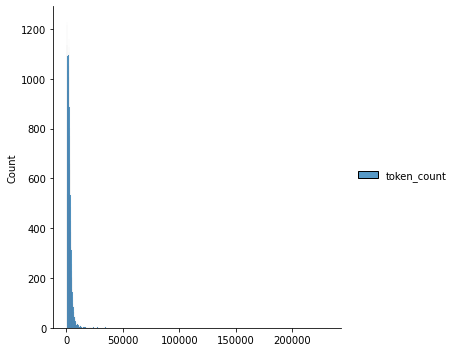

In [26]:
sns.displot(tokenized_filtered_text.select("token_count").toPandas())

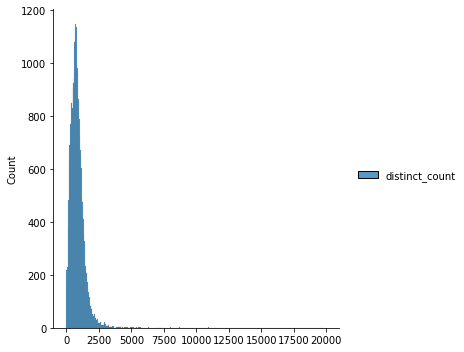

In [27]:
sns.displot(tokenized_filtered_text.select("distinct_count").toPandas())

In [28]:
tokenized_filtered_text.write.save("hdfs://namenode:8020/output/tokenized_filtered_text.parquet", format="parquet")

In [4]:
tokenized_filtered_text = spark.read.load("hdfs://namenode:8020/output/tokenized_filtered_text.parquet", format="parquet")

In [5]:
rdd_count = tokenized_filtered_text.select("filtered_words").rdd.flatMap(lambda x: x[0])

In [19]:
rdd_res = rdd_count.filter(lambda x: len(x) > 2).map(lambda x: (x, 1)).reduceByKey(lambda x, y: x+y)

In [20]:
rdd_res = rdd_res.map(lambda x: (x[1], x[0])).sortByKey(False).top(50)

In [21]:
rdd_res

[(353048, 'patients'),
 (273792, 'usepackage'),
 (262527, 'cells'),
 (248535, 'also'),
 (235814, 'may'),
 (226129, 'virus'),
 (215129, 'infection'),
 (214827, 'covid'),
 (200282, 'study'),
 (190000, 'data'),
 (182658, 'disease'),
 (180641, 'using'),
 (180285, 'used'),
 (160689, 'one'),
 (159561, 'cell'),
 (158943, 'sars'),
 (153878, 'viral'),
 (151797, 'cov'),
 (151094, 'time'),
 (150970, 'health'),
 (143680, 'protein'),
 (143019, 'two'),
 (134326, 'however'),
 (130317, 'results'),
 (128375, 'cases'),
 (127315, 'studies'),
 (125777, 'high'),
 (123628, 'based'),
 (122104, 'clinical'),
 (119964, 'fig'),
 (118075, 'number'),
 (115985, 'use'),
 (114916, 'different'),
 (114759, 'human'),
 (114438, 'treatment'),
 (113197, 'risk'),
 (109121, 'well'),
 (107317, 'analysis'),
 (105130, 'associated'),
 (105005, 'reported'),
 (103973, 'respiratory'),
 (101808, 'first'),
 (101024, 'model'),
 (98610, 'infected'),
 (97120, 'group'),
 (96570, 'found'),
 (94479, 'specific'),
 (94277, '2020'),
 (93415, 

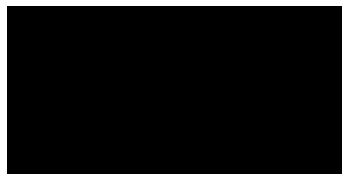

In [25]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import random

word_cloud_list = []

for line in rdd_res:
    count = line[0]
    word = line[1]
    actual_count = int(count * 0.0001)
    for i in range(actual_count):
        word_cloud_list.append(word)

random.shuffle(word_cloud_list)
print(word_cloud_list
str1 = ''.join(word_cloud_list)
    
wordcloud = WordCloud().generate(str1)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [14]:
!pip3 install wordcloud

# 4. Vectorization of Text using SparkML

## 4.1 Using TF-IDF to extract top 3000 tf-idf features
using tf-idf vectorization to extract top 3000 tf-idf features from the original tokenized text. Since we only extracet top 3000, it can alse act as a noice remover.

In [5]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer

In [6]:
hashingTF = HashingTF(inputCol="filtered_words", outputCol="rowFeatures", numFeatures=3000)
featurizedData = hashingTF.transform(tokenized_filtered_text)
idf = IDF(inputCol="rowFeatures", outputCol="tf_idf_features")
idfModel = idf.fit(featurizedData)
tf_idf_data = idfModel.transform(featurizedData)
tf_idf_data = tf_idf_data.select("paper_id", "tf_idf_features")
tf_idf_data.show(1)

+--------------------+--------------------+
|            paper_id|     tf_idf_features|
+--------------------+--------------------+
|44477eaafa89581df...|(3000,[3,26,43,65...|
+--------------------+--------------------+
only showing top 1 row



In [7]:
tf_idf_data.write.save("hdfs://namenode:8020/output/tf_idf_data.parquet", format="parquet")

In [20]:
tf_idf_data = spark.read.load("hdfs://namenode:8020/output/tf_idf_data.parquet", format="parquet")

## Word2Vec

In [6]:
from pyspark.ml.feature import Word2Vec

# Input data: Each row is a bag of words from a sentence or document.
# Learn a mapping from words to Vectors.
word2Vec = Word2Vec(vectorSize=100, minCount=0, inputCol="filtered_words", outputCol="features").setNumPartitions(10).setStepSize(0.1)
model = word2Vec.fit(tokenized_filtered_text)

word2vec_features = model.transform(tokenized_filtered_text)
word2vec_features = word2vec_features.select("paper_id", "features")
word2vec_features.show(1)

+--------------------+--------------------+
|            paper_id|            features|
+--------------------+--------------------+
|44477eaafa89581df...|[0.71883760433644...|
+--------------------+--------------------+
only showing top 1 row



In [7]:
word2vec_features.write.save("hdfs://namenode:8020/output/word2vec_features.parquet", format="parquet")

In [3]:
word2vec_features = spark.read.load("hdfs://namenode:8020/output/word2vec_features.parquet", format="parquet")

## 4.2 Using PCA to reduce the dimension of our features
Use PCA do reduce the dimension of our feature to 1000.
We can see that while we reduce the feature dimensions to 1000, we keep 95% variance.

In [11]:
from pyspark.ml.feature import PCA
pca = PCA(k=1000, inputCol="tf_idf_features", outputCol="pca_features")
model = pca.fit(tf_idf_data)
pca_features = model.transform(tf_idf_data).select("paper_id", "pca_features")

In [15]:
model.explainedVariance.sum()

0.9569113194205373

In [17]:
pca_features.show(n=2)

+--------------------+--------------------+
|            paper_id|        pca_features|
+--------------------+--------------------+
|44477eaafa89581df...|[-0.0744166916291...|
|ce6717ad3bb0da860...|[-455.16880607120...|
+--------------------+--------------------+
only showing top 2 rows



In [18]:
pca_features.write.save("hdfs://namenode:8020/output/pca_features.parquet", format="parquet")

In [43]:
pca_features = spark.read.load("hdfs://namenode:8020/output/pca_features.parquet", format="parquet")

# 5. Clustering and Visualization

In [44]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import BisectingKMeans

In [45]:
kmeans = KMeans().setFeaturesCol("pca_features").setPredictionCol("prediction").setK(20).setSeed(7)
model = kmeans.fit(pca_features)
predictions = model.transform(pca_features)
evaluator = ClusteringEvaluator().setFeaturesCol("pca_features")
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))
results = predictions.select("paper_id", "prediction").collect()
id_cluster = {}
cluster_count = {}
for item in results:
    id = str(item[0])
    cluster = str(item[1])
    id_cluster[id] = cluster
    if cluster not in cluster_count:
        cluster_count[cluster] = 1
    else:
        cluster_count[cluster] += 1
print(cluster_count)

Silhouette with squared euclidean distance = 0.8733530911316482
{'0': 29161, '10': 49, '13': 65, '16': 93, '18': 126, '14': 322, '1': 2, '3': 22, '11': 27, '12': 13, '2': 5, '7': 15, '5': 2, '6': 1, '9': 4, '19': 8, '17': 1, '15': 37, '8': 1, '4': 1}


## Word2Vec

In [19]:
kmeans = KMeans().setK(20).setSeed(20).setPredictionCol("prediction")
model = kmeans.fit(word2vec_features)
predictions = model.transform(word2vec_features)
evaluator = ClusteringEvaluator().setFeaturesCol("features")
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))
results = predictions.select("paper_id", "prediction").collect()
id_cluster = {}
cluster_count = {}
for item in results:
    id = str(item[0])
    cluster = str(item[1])
    id_cluster[id] = cluster
    if cluster not in cluster_count:
        cluster_count[cluster] = 1
    else:
        cluster_count[cluster] += 1
print(cluster_count)

Silhouette with squared euclidean distance = 0.19524161402856402
{'2': 1520, '11': 183, '0': 2595, '1': 2506, '12': 1948, '7': 1889, '9': 1676, '17': 1704, '13': 3289, '10': 1505, '4': 3050, '5': 1915, '19': 1352, '18': 1507, '14': 775, '15': 1691, '3': 407, '8': 150, '16': 150, '6': 143}


In [68]:
from pyspark.ml.feature import PCA
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
model = pca.fit(word2vec_features)
pca_feature_2 = model.transform(word2vec_features).select("paper_id", "pca_features")

In [69]:
X = pca_feature_2.toPandas()
X

,paper_id,pca_features
0,2d8f5b4b46a2ba3e91d7c203d6c000e7b52bd1de,"[-3.5020671611011363, 0.8782620633784763]"
1,94ae2a433f8ad7ccc4bc75b2b189c4977c159cde,"[4.574828108919724, -6.763795804664904]"
2,c0adec09d50c27499189a7b33d82ae1d89c7419d,"[-4.997860439213445, 0.010254343817363606]"
3,187e218760da40c6a7dd3d3229535a1fd5217228,"[-5.768954752995544, -1.7575486390967856]"
4,8da240aec06e75fecb39f229f3604a3240f1baa9,"[-5.607244650473107, -1.2964894478929694]"
...,...,...
29950,PMC7100455,"[3.387153401430029, -6.792963345351959]"
29951,PMC7245219,"[2.1048654037956425, -4.576186783365428]"
29952,PMC7245180,"[3.5653418080670765, -7.569060083396118]"
29953,PMC7537205,"[-2.616182853303089, -1.5418809476306479]"


In [70]:
X_value = X["pca_features"].values

In [71]:
import numpy as np
tmp1 = []
for a in X_value:
    tmp2 = []
    for b in a:
        tmp2.append(b)
    tmp1.append(tmp2)
X_value_np = np.array(tmp1)

In [72]:
X_id = X["paper_id"].values

In [73]:
values = []
for id in X_id:
    values.append(id_cluster[id])


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


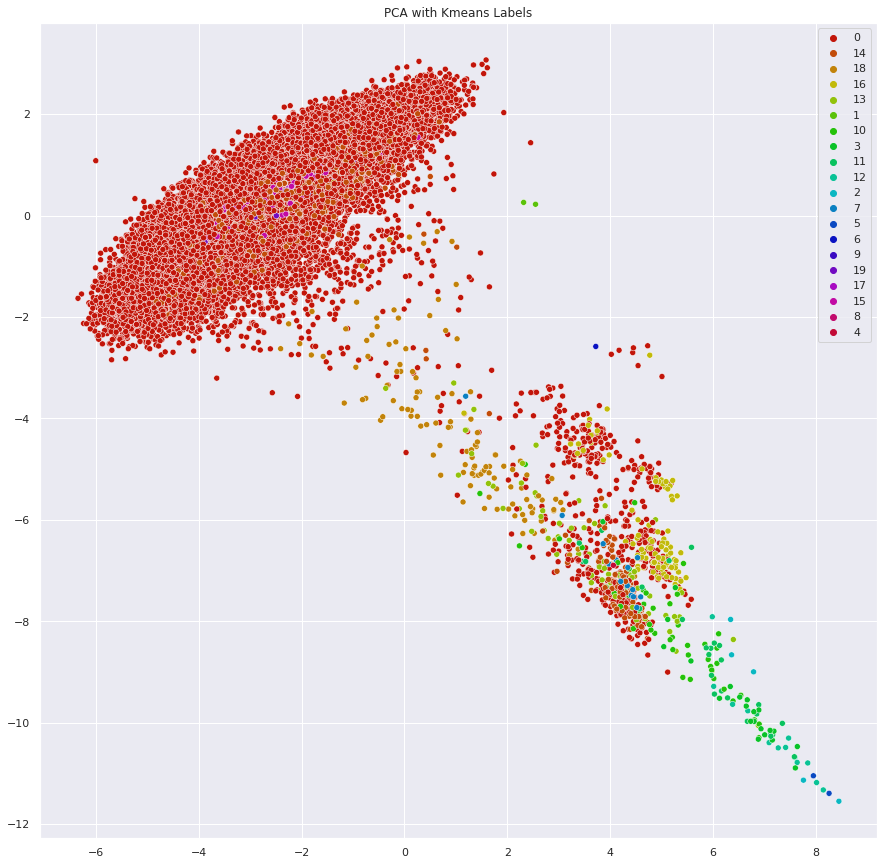

In [74]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.hls_palette(20, l=.4, s=.9)

# plot
sns.scatterplot(X_value_np[:,0], X_value_np[:,1], hue=values, legend='full', palette=palette)
plt.title('PCA with Kmeans Labels')
plt.savefig("improved_cluster_tsne.png")
plt.show()